## Preliminaries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, confusion_matrix, root_mean_squared_error, classification_report, make_scorer
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate

import time

In [ ]:
X_train_processed = np.loadtxt(r'./../data/X_train_processed.csv', delimiter = ',')
y_train = np.loadtxt(r'./../data/y_train.csv', delimiter = ',')

In [3]:
columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'acid_sugar', 'acid_alc', 'alc_sugar', 'sulf_sugar']

df_train_processed = pd.DataFrame(np.hstack((X_train_processed, y_train[:, None] )), columns = columns + ['quality'])

In [4]:
df_train_processed.columns[6]

'total sulfur dioxide'

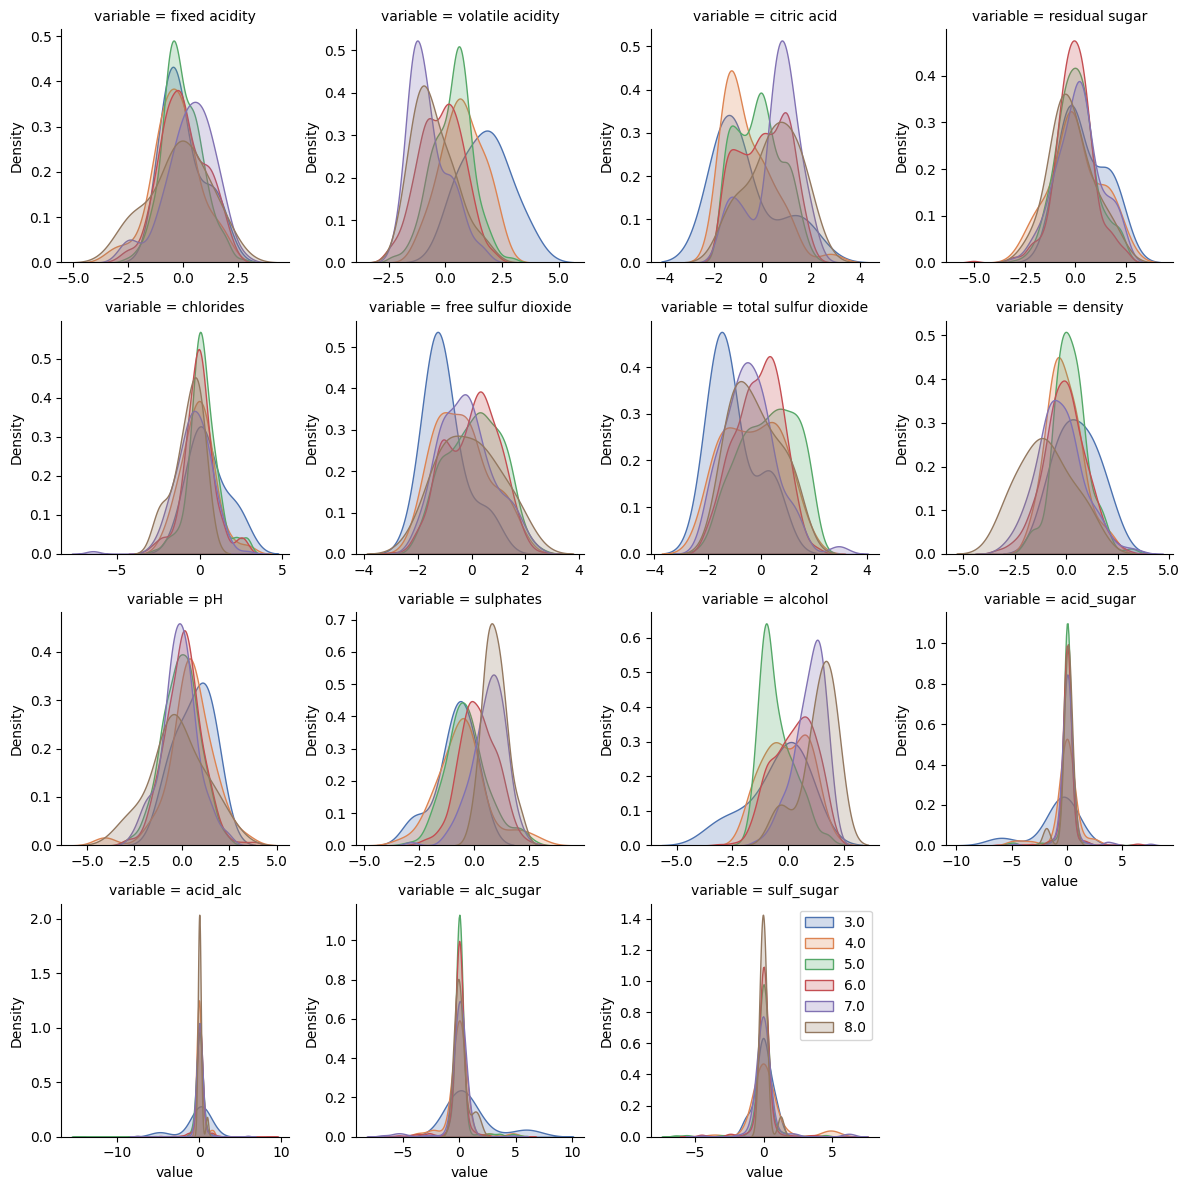

In [5]:
# check if the distributions 'look' Gaussian

df = pd.melt(df_train_processed, df_train_processed.columns[-1], df_train_processed.columns[:-1])

g = sns.FacetGrid(df, col="variable", hue="quality", col_wrap=4, sharex=False, sharey=False,  palette="deep")
g.map(sns.kdeplot, "value", label='quality', fill=True)
plt.legend()

## Two Quick Models

#### Let's try some Gaussian Naive Bayes classifieres by hand

First try with the whole dataset, then remove (arbitrarily) some columns from the data. In theory, Naive Bayes works better:
    
    - with fewer features 
    - when features are independent from each other

In [6]:
classes = [f"Class {i}" for i in range(3,9)]

# function to print results
def print_scores(y_true, y_pred, target_names):

    print("Root mean squared error (on entire X_train) =", np.round(root_mean_squared_error(y_true, y_pred),3))
    print("---------------------------------------------")
    #print("Individual f1 scores: ", f1_score(y_train, y_pred, average = None))
    print("Confusion matrix :\n", confusion_matrix(y_true, y_pred))
    print("---------------------------------------------")
    print("Classification report :\n", classification_report(y_true, y_pred, target_names=target_names))

def plot_confusion(con_matrix):
    
    fig, ax = plt.subplots()
    ax = sns.heatmap(con_matrix, annot=True, linewidth=.5)
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')

    return fig

Root mean squared error (training) = 0.918 ± 0.037
Root mean squared error (cross-val) = 0.955 ± 0.039
---------------------------------------------
Root mean squared error (on entire X_train) = 0.941
---------------------------------------------
Confusion matrix :
 [[  5   1   2   0   0   0]
 [  0  13  17  10   2   0]
 [ 11  28 318  87  13   4]
 [  5  22 144 167  51  39]
 [  1   3   7  36  52  35]
 [  0   0   0   1   2  11]]
---------------------------------------------
Classification report :
               precision    recall  f1-score   support

     Class 3       0.23      0.62      0.33         8
     Class 4       0.19      0.31      0.24        42
     Class 5       0.65      0.69      0.67       461
     Class 6       0.55      0.39      0.46       428
     Class 7       0.43      0.39      0.41       134
     Class 8       0.12      0.79      0.21        14

    accuracy                           0.52      1087
   macro avg       0.36      0.53      0.39      1087
weighted av

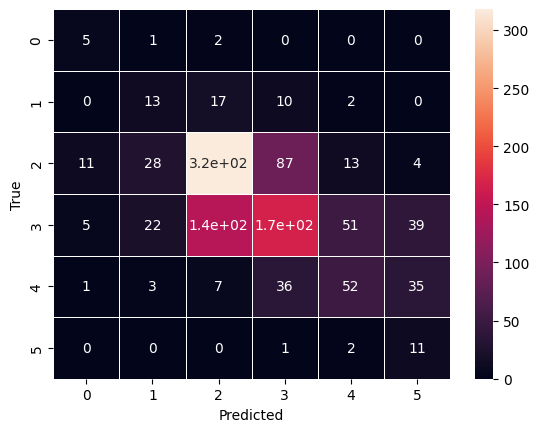

In [7]:
clf = GaussianNB()
clf.fit(X_train_processed, y_train)
#print(clf.score(X_train_processed, y_train))

cv_dict = cross_validate(clf, X_train_processed, y_train, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1, return_train_score=True)

print("Root mean squared error (training) =", round(-cv_dict['train_score'].mean(),3), u"\u00B1", round(cv_dict['train_score'].std(),3))
print("Root mean squared error (cross-val) =", round(-cv_dict['test_score'].mean(),3), u"\u00B1", round(cv_dict['test_score'].std(),3))
print("---------------------------------------------")

y_pred = clf.predict(X_train_processed)

print_scores(y_train, y_pred, classes)

plot_confusion(confusion_matrix(y_train, y_pred))
plt.show()

The new features we added during preprocessing are ratios of existing features, so intuitively these added features are not independent from the existing features. Therefore it seems reasonable to drop them.

Root mean squared error (training) = 0.786 ± 0.017
Root mean squared error (cross-val) = 0.824 ± 0.037
---------------------------------------------
Root mean squared error (on entire X_train) = 0.785
---------------------------------------------
Confusion matrix :
 [[  4   1   3   0   0   0]
 [  1   8  19  12   2   0]
 [  8  11 339  89  14   0]
 [  0   8 155 186  75   4]
 [  0   1   7  41  79   6]
 [  0   0   0   3   8   3]]
---------------------------------------------
Classification report :
               precision    recall  f1-score   support

     Class 3       0.31      0.50      0.38         8
     Class 4       0.28      0.19      0.23        42
     Class 5       0.65      0.74      0.69       461
     Class 6       0.56      0.43      0.49       428
     Class 7       0.44      0.59      0.51       134
     Class 8       0.23      0.21      0.22        14

    accuracy                           0.57      1087
   macro avg       0.41      0.44      0.42      1087
weighted av

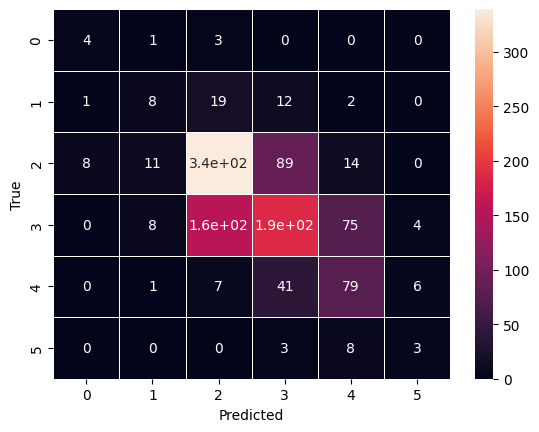

In [8]:
X_train_drop = X_train_processed[:, :11]

clf = GaussianNB()
clf.fit(X_train_drop, y_train)
#print("Accuracy score = ", np.round(clf.score(X_train_drop, y_train),3))

cv_dict = cross_validate(clf, X_train_drop, y_train, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1, return_train_score=True)

print("Root mean squared error (training) =", round(-cv_dict['train_score'].mean(),3), u"\u00B1", round(cv_dict['train_score'].std(),3))
print("Root mean squared error (cross-val) =", round(-cv_dict['test_score'].mean(),3), u"\u00B1", round(cv_dict['test_score'].std(),3))
print("---------------------------------------------")

y_pred = clf.predict(X_train_drop)

print_scores(y_train, y_pred, classes)
plot_confusion(confusion_matrix(y_train, y_pred))
plt.show()

Indeed, this leads to better scores as compared to keeping all the columns.

## Fine-tuning models with GridSearch

Next we want to perform a more exhaustive hyperparameter search. Naive Bayes does not have any hyperparameter to vary, so I will perform (kernel)PCA and vary the number of components and kernel type/parameters using `GridSearch`. Again, I will drop the columns that we added to the initial dataset, as they are not independent.

To vary parameters inside `KernelPCA`, we build a pipeline and used it as an estimator inside the `GridSearch`.

In [9]:
# build pipeline

pipe = make_pipeline(KernelPCA(random_state=42, n_jobs=-1), StandardScaler(), GaussianNB())

In [10]:
# perfom gridsearch

X_train_naiveb = X_train_processed[:,:11]

# KernelPCA(n_components=None, kernel='rbf', gamma=None, degree=3, coef0=1, random_state=42, n_jobs=-1)
params=[{'kernelpca__n_components': np.arange(5, X_train_naiveb.shape[1]),
         'kernelpca__kernel': ['linear']}, # 6 combinations
        {'kernelpca__n_components': np.arange(5, X_train_naiveb.shape[1]),
         'kernelpca__kernel': ['rbf'],
         'kernelpca__gamma': [None, 0.0001, 0.001, 0.01, 0.1, 1]}, # 6*6 = 36 combinations
        {'kernelpca__n_components': np.arange(5, X_train_naiveb.shape[1]),
         'kernelpca__kernel': ['poly'],
         'kernelpca__gamma': [None, 0.0001, 0.001, 0.01, 0.1, 1],
         'kernelpca__degree': [2, 3, 4]} # 6*6*3 = 108 combiations
         ] # total = 150 combinations


# custom scoring function
def f1_custom_weighted_fct(y_true, y_pred):
    weights = np.array([0,0,0,0,0,1]) # relative importances of getting a given wine class right
    weights = weights / weights.sum() # weights must always sum to 1
    f1_scores = f1_score(y_true, y_pred, average=None)
    return f1_scores @ weights

# define the function as a score
f1_custom_weighted_scorer = make_scorer(f1_custom_weighted_fct, greater_is_better=True)

# Combine scorers in a dictionary
scorers = {
    'neg_root_mean_squared_error': 'neg_root_mean_squared_error',
    'f1_macro': 'f1_macro',
    'f1_weighted': 'f1_weighted',
    'top_k_accuracy': 'top_k_accuracy',
    'f1_weighted_custom': f1_custom_weighted_scorer
}


start = time.time()

clf = GridSearchCV(pipe, params, scoring = scorers, n_jobs=-1, cv=5, refit = 'neg_root_mean_squared_error', return_train_score=True)
clf.fit(X_train_naiveb, y_train)
end = time.time() 

print(end-start) # ~80 sec for 150 combinations


# pack the cv results in a dataframe
cv_res_df = pd.DataFrame({k:v for k, v in clf.cv_results_.items() if not k.endswith('time')|k.startswith('split')|k.startswith('params')})
cv_res_df = cv_res_df.sort_values('rank_test_neg_root_mean_squared_error')

165.46763920783997


In `f1_custom_weighted_fct` I set null weights to all wine classes except for the best, to see how many 8's I can get correctly. 

It was not possible to get more than 3 out of 14.

In [11]:
# inspect the 10 best estimators (according to rmse)
cv_res_df.head(10)

,param_kernelpca__kernel,param_kernelpca__n_components,param_kernelpca__gamma,param_kernelpca__degree,mean_test_neg_root_mean_squared_error,std_test_neg_root_mean_squared_error,rank_test_neg_root_mean_squared_error,mean_train_neg_root_mean_squared_error,std_train_neg_root_mean_squared_error,mean_test_f1_macro,...,mean_test_top_k_accuracy,std_test_top_k_accuracy,rank_test_top_k_accuracy,mean_train_top_k_accuracy,std_train_top_k_accuracy,mean_test_f1_weighted_custom,std_test_f1_weighted_custom,rank_test_f1_weighted_custom,mean_train_f1_weighted_custom,std_train_f1_weighted_custom
8,rbf,7,None,NaN,-0.752484,0.022144,1,-0.745874,0.004146,0.300643,...,0.862935,0.016244,81,0.872127,0.004697,0.000000,0.000000,98,0.064103,0.078614
20,rbf,7,0.001,NaN,-0.755173,0.031324,2,-0.738090,0.008372,0.297514,...,0.878552,0.011230,1,0.892824,0.003822,0.000000,0.000000,98,0.115110,0.058513
22,rbf,9,0.001,NaN,-0.755361,0.026489,3,-0.719766,0.010306,0.304855,...,0.868431,0.009653,61,0.887994,0.006083,0.066667,0.133333,60,0.266651,0.033730
92,poly,7,0.001,3.0,-0.755852,0.029549,4,-0.741059,0.006977,0.299265,...,0.877631,0.011247,2,0.891674,0.004210,0.000000,0.000000,98,0.138108,0.091160
16,rbf,9,0.0001,NaN,-0.755996,0.025778,5,-0.720718,0.010698,0.304266,...,0.867514,0.009961,71,0.888224,0.005076,0.066667,0.133333,60,0.248756,0.035000
56,poly,7,0.001,2.0,-0.756457,0.029601,6,-0.740740,0.007859,0.297764,...,0.877631,0.011247,2,0.891674,0.004210,0.000000,0.000000,98,0.138108,0.091160
4,linear,9,NaN,NaN,-0.756600,0.025835,7,-0.721203,0.010263,0.303677,...,0.867514,0.009961,71,0.887994,0.004762,0.066667,0.133333,60,0.248756,0.035000
23,rbf,10,0.001,NaN,-0.756662,0.024378,8,-0.724259,0.007637,0.310616,...,0.867514,0.009085,64,0.887534,0.004590,0.066667,0.133333,60,0.284921,0.044359
21,rbf,8,0.001,NaN,-0.756785,0.036179,9,-0.735716,0.010949,0.317574,...,0.873035,0.015611,35,0.892363,0.003336,0.080000,0.160000,46,0.134299,0.011508
2,linear,7,NaN,NaN,-0.757033,0.030412,10,-0.740411,0.009405,0.296200,...,0.876713,0.009514,6,0.892594,0.003755,0.000000,0.000000,98,0.138108,0.091160


In [12]:
# quick look at all crossval scores

mean_cv_scores = cv_res_df[[col for col in cv_res_df.columns if col.startswith('mean_test')]]

mean_cv_scores.sort_values('mean_test_f1_weighted_custom', ascending = False).head(5)

,mean_test_neg_root_mean_squared_error,mean_test_f1_macro,mean_test_f1_weighted,mean_test_top_k_accuracy,mean_test_f1_weighted_custom
68,-0.813738,0.326339,0.526661,0.858301,0.240000
73,-1.031367,0.256403,0.385415,0.787486,0.220000
67,-0.814739,0.343617,0.525006,0.861070,0.216364
72,-1.022260,0.224156,0.385820,0.791160,0.216364
74,-1.036976,0.257289,0.393600,0.785642,0.216364


In [13]:
check_overfitting = cv_res_df[[col for col in cv_res_df.columns if col.startswith('mean_test') | col.startswith('mean_train')]]
col_1 = check_overfitting['mean_train_neg_root_mean_squared_error']
col_2 = check_overfitting['mean_test_neg_root_mean_squared_error']

# max relative deviation between train and cv scores is 7% => no overfitting
(-(col_1 - col_2)/col_1).describe()

count    150.000000
mean       0.023521
std        0.020713
min       -0.019649
25%        0.012863
50%        0.022716
75%        0.032767
max        0.074481
dtype: float64

## Confusion matrices from GridSearch

Here I plot the confusion matrices for the best estimators that came out of the GridSearch.

In [14]:
def top_k_best_classifiers(gridsearch_instance, k, score):
    
    dictionary = gridsearch_instance.cv_results_
    df = pd.DataFrame(dictionary).sort_values('rank_test_' + score)
    indexes = df.head(k).index
    new_dict = [dictionary['params'][i] for i in indexes]
    new_dict = [{key: [value] for key, value in d.items()} for d in new_dict] # dict packed like this in order to feed to gridsearch
    
    return new_dict

def top_confusion_matrices(gridsearch_instance, k, score, X, y_true):

    params = top_k_best_classifiers(gridsearch_instance, k, score)
    for i, param_dict in enumerate(params):
        pipe = make_pipeline(KernelPCA(random_state=42, n_jobs=-1), StandardScaler(), GaussianNB())
        classifier = GridSearchCV(pipe, param_dict, n_jobs=-1, cv=5, return_train_score=False)
        classifier.fit(X, y_true)
        y_pred = classifier.predict(X)
        con_matrix = confusion_matrix(y_true, y_pred)
        plot_confusion(con_matrix)

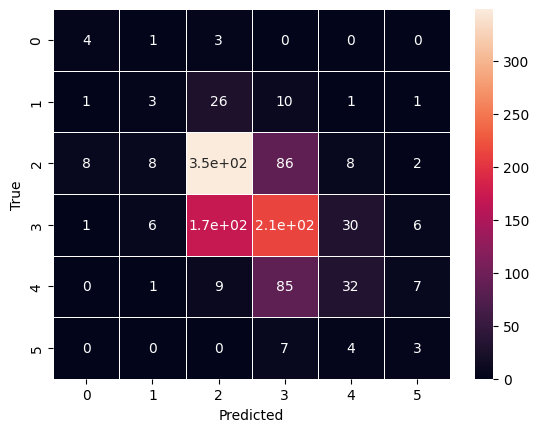

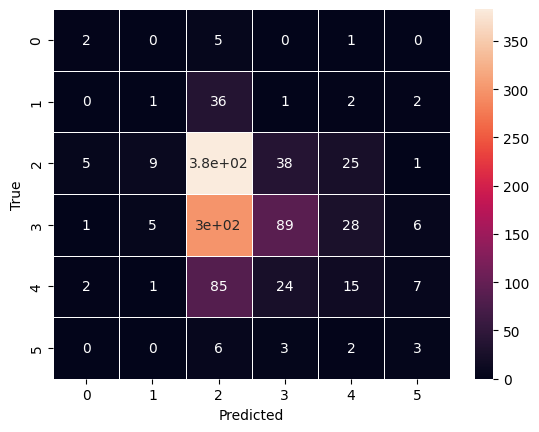

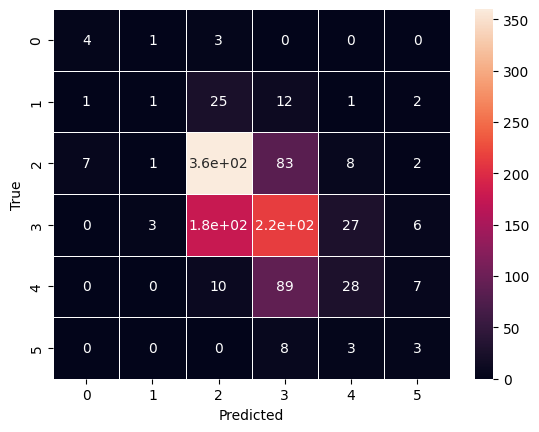

In [15]:
top_confusion_matrices(gridsearch_instance = clf, k = 3, score = 'f1_weighted_custom', X = X_train_naiveb, y_true = y_train)

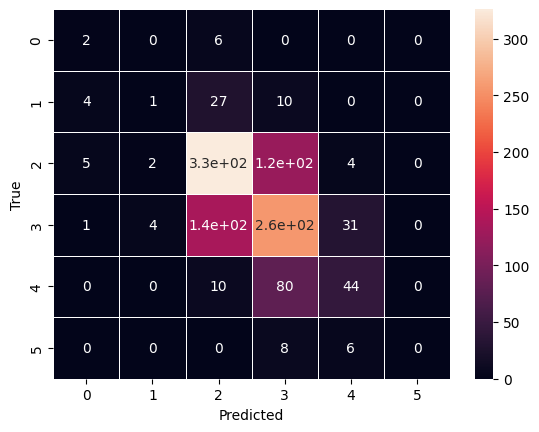

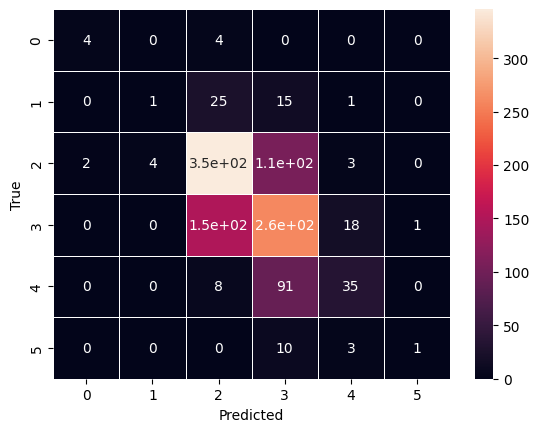

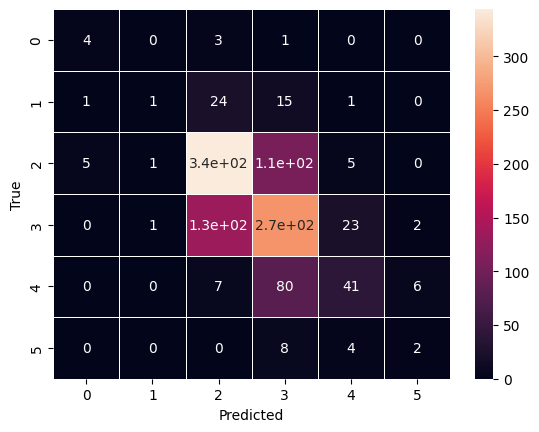

In [16]:
top_confusion_matrices(gridsearch_instance = clf, k = 3, score = 'neg_root_mean_squared_error', X = X_train_naiveb, y_true = y_train)

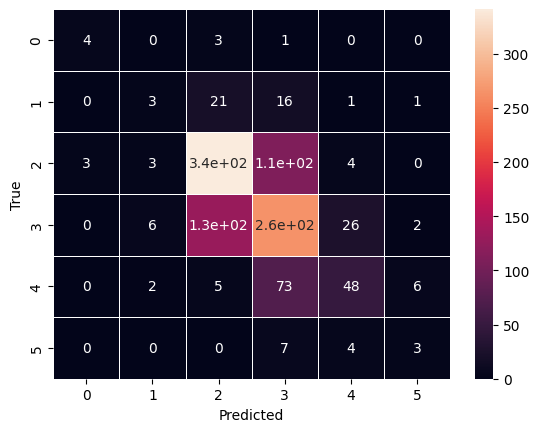

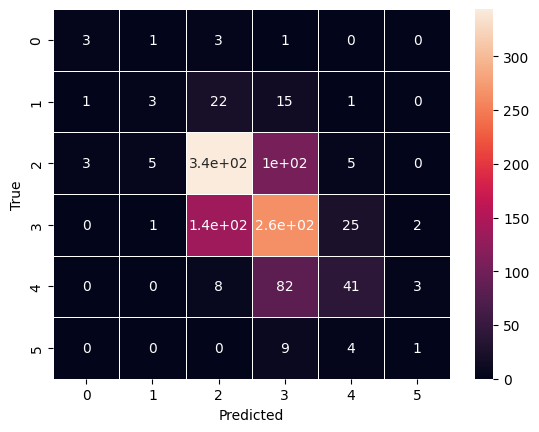

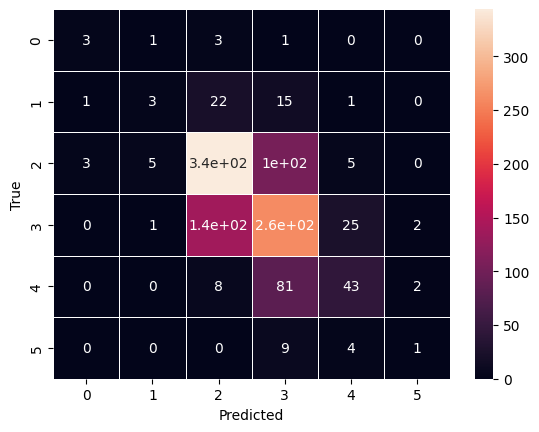

In [17]:
top_confusion_matrices(gridsearch_instance = clf, k = 3, score = 'f1_weighted', X = X_train_naiveb, y_true = y_train)

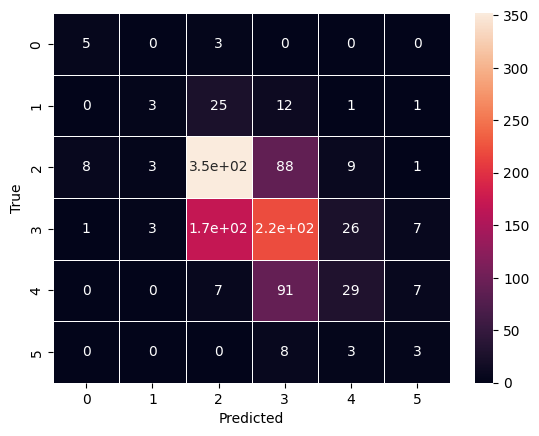

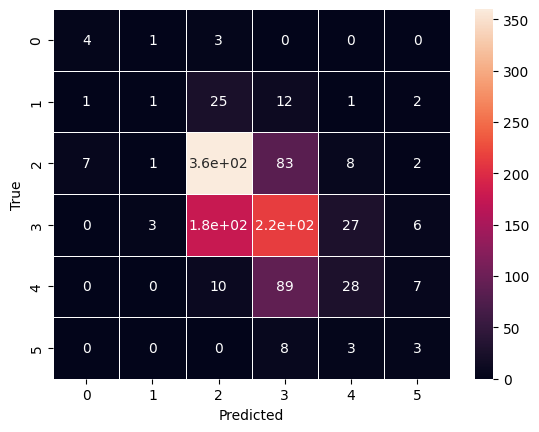

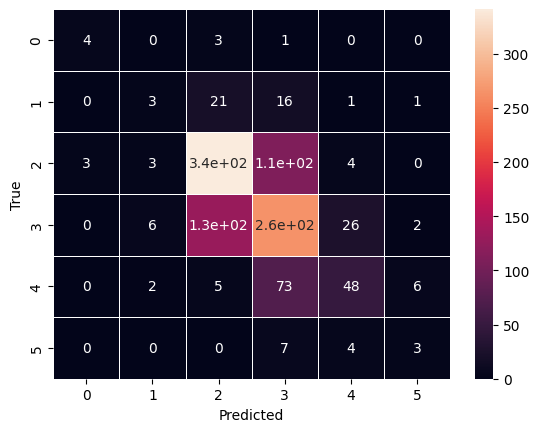

In [18]:
top_confusion_matrices(gridsearch_instance = clf, k = 3, score = 'f1_macro', X = X_train_naiveb, y_true = y_train)

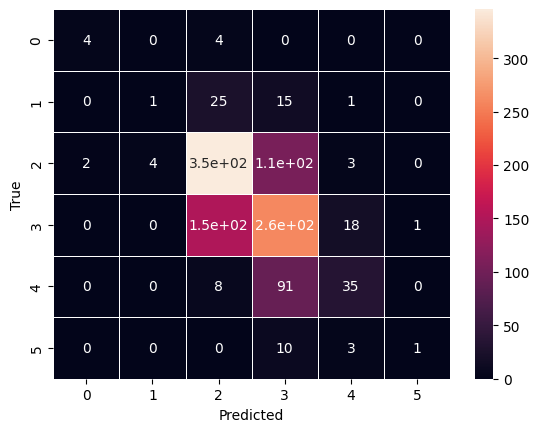

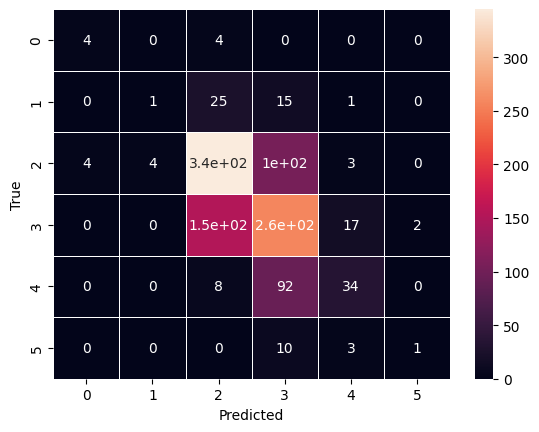

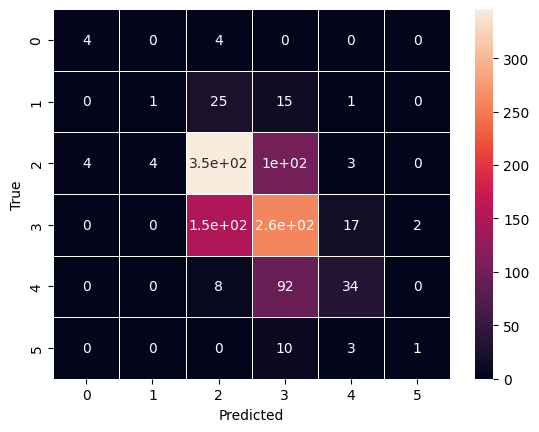

In [19]:
top_confusion_matrices(gridsearch_instance = clf, k = 3, score = 'top_k_accuracy', X = X_train_naiveb, y_true = y_train)

#### Interestingly, it seeems that GridSearch did not lead to drastical improvements with respect to the initial tries...